In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [51]:
# Load dataset
df = pd.read_csv(r"C:\Data Set\Airline+Passenger+Satisfaction\Airline_passenger_satisfaction.csv")

In [52]:

print(df.shape)
df.head()

(129880, 24)


,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,...,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,...,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,...,3,4,4,5,4,3,3,3,3,Satisfied


In [53]:
#Data cleaning 
df.dropna(inplace=True)  # drop missing values


In [54]:

df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]


In [55]:
df.isnull().sum()


ID                                        0
Gender                                    0
Age                                       0
Customer_Type                             0
Type_of_Travel                            0
Class                                     0
Flight_Distance                           0
Departure_Delay                           0
Arrival_Delay                             0
Departure_and_Arrival_Time_Convenience    0
Ease_of_Online_Booking                    0
Check_in_Service                          0
Online_Boarding                           0
Gate_Location                             0
On_board_Service                          0
Seat_Comfort                              0
Leg_Room_Service                          0
Cleanliness                               0
Food_and_Drink                            0
In_flight_Service                         0
In_flight_Wifi_Service                    0
In_flight_Entertainment                   0
Baggage_Handling                

In [56]:
# missing Arrival Delay with median
df["Arrival_Delay"] = df["Arrival_Delay"].fillna(df["Arrival_Delay"].median())

# Convert target to binary (make sure strings match your dataset exactly)
df["Satisfaction"] = df["Satisfaction"].str.strip().str.lower().map({
    "satisfied": 1,
    "neutral or dissatisfied": 0
})

# ID column 
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

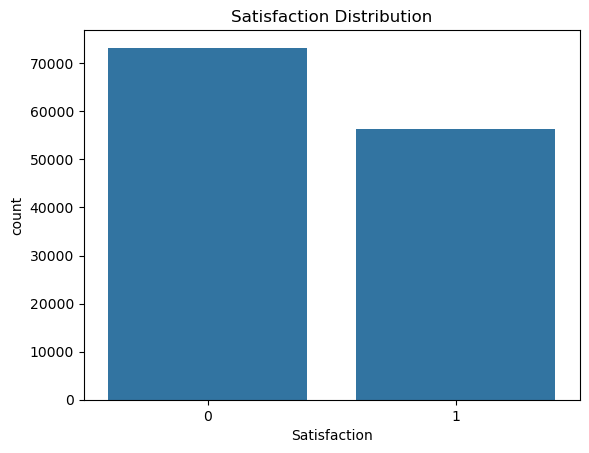

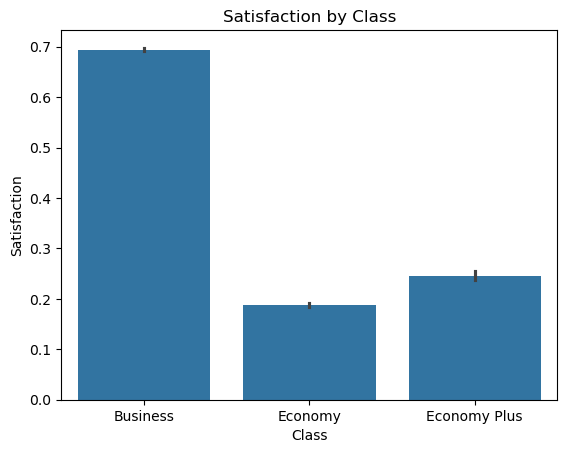

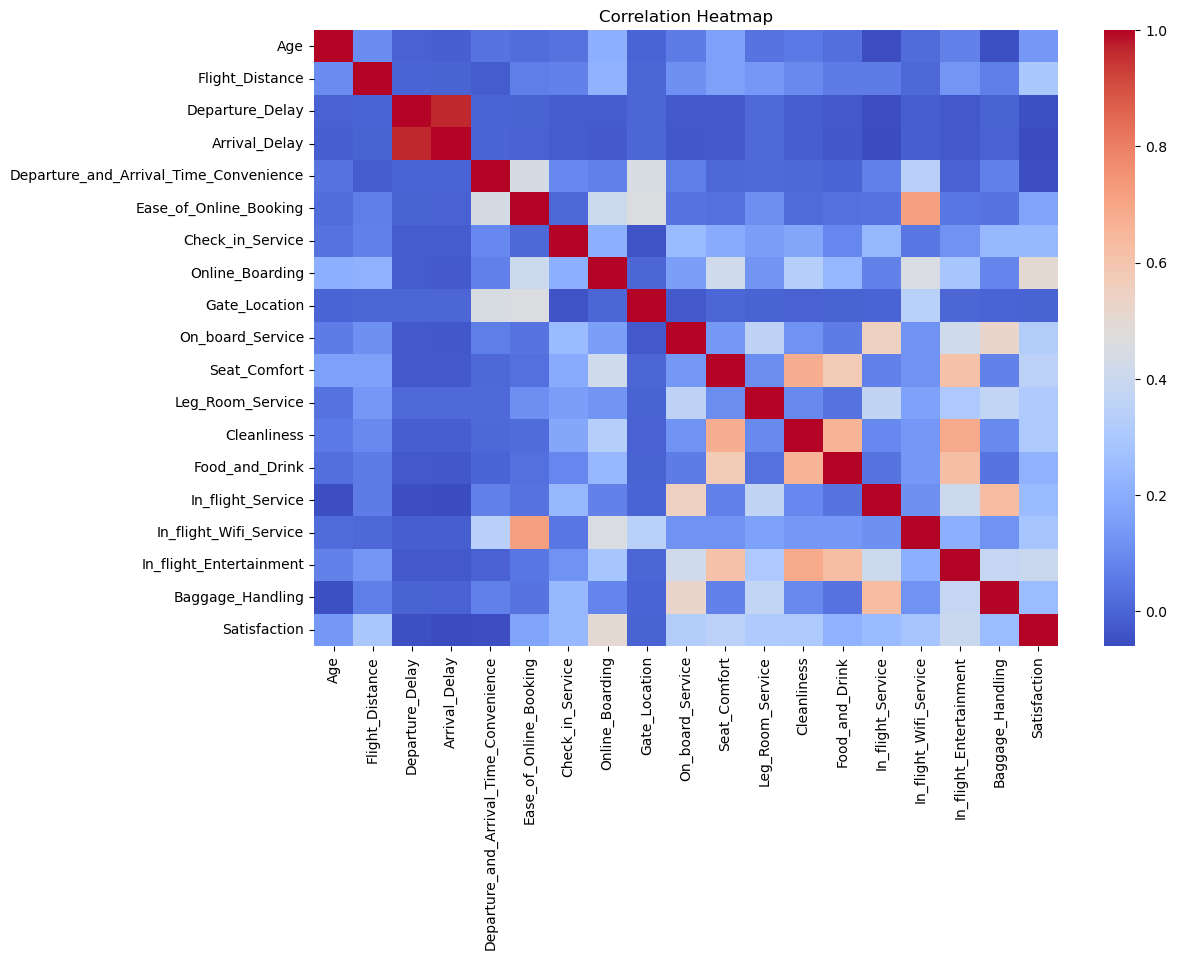

In [57]:
# Satisfaction distribution
sns.countplot(x="Satisfaction", data=df)
plt.title("Satisfaction Distribution")
plt.show()

# Satisfaction by Class
sns.barplot(x="Class", y="Satisfaction", data=df)
plt.title("Satisfaction by Class")
plt.show()

# Correlation with service features
plt.figure(figsize=(12,8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [58]:
categorical_cols = ["Gender", "Customer_Type", "Type_of_Travel", "Class"]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop("Satisfaction", axis=1)
y = df_encoded["Satisfaction"]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n{'='*40}")
    print(f"  {name}")
    print(f"{'='*40}")
    print(classification_report(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, proba))

    results[name] = roc_auc_score(y_test, proba)

print("\n── ROC AUC Summary ──")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {score:.4f}")


  Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14645
           1       0.87      0.84      0.85     11253

    accuracy                           0.88     25898
   macro avg       0.87      0.87      0.87     25898
weighted avg       0.88      0.88      0.87     25898

ROC AUC: 0.9277904876138335

  Random Forest
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14645
           1       0.97      0.94      0.96     11253

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898

ROC AUC: 0.993943896361524

  Gradient Boosting
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14645
           1       0.95      0.92      0.93     11253

    accuracy                           0.94     25898
   macro avg

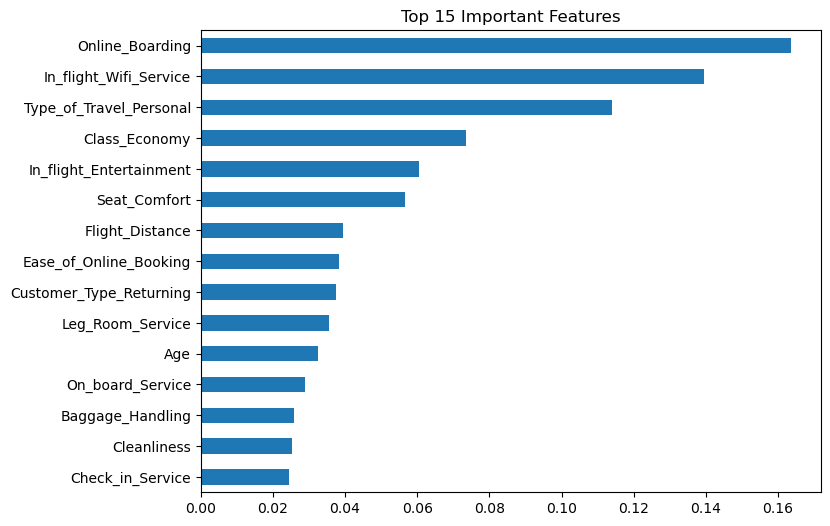

In [65]:
rf = models["Random Forest"]

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
top_features.plot(kind="barh")
plt.title("Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()

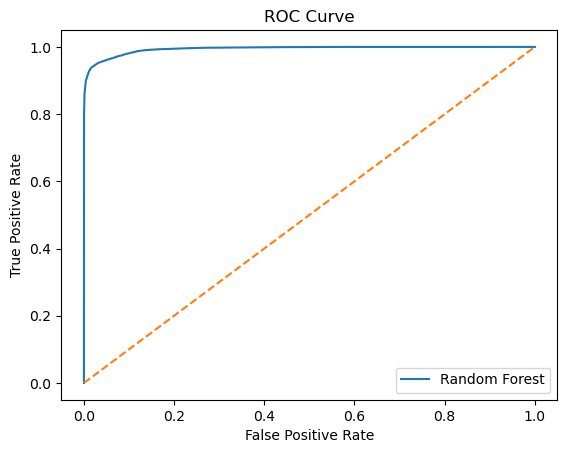

In [66]:
best_model = models["Random Forest"]
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

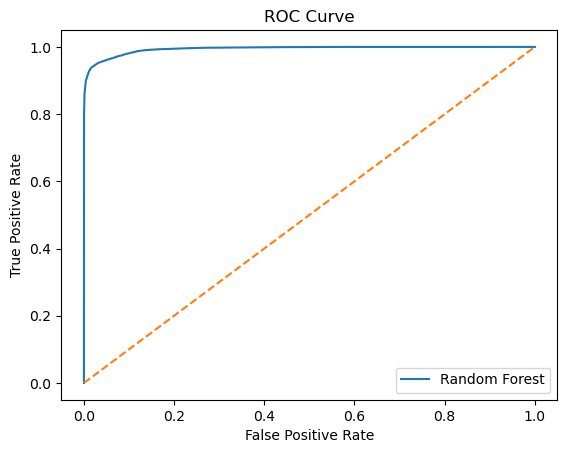

In [67]:
best_model = models["Random Forest"]
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [68]:
import joblib

joblib.dump(best_model, "airline_satisfaction_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a sample plot
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x)
plt.figure()
plt.plot(x, y)
plt.title("Sine Wave")

# Save the figure to a file
image_path = 'sine_wave_plot.png'
plt.savefig(image_path)
plt.close() # Close the plot to free memory

print(f"Saved plot to {image_path}")

Saved plot to sine_wave_plot.png
